In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('/content/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [5]:
# splitting dataset into training, validation/development , test set || building the dataset
block_size = 3 # context size that we will feed
def build_dataset(words):
  X, Y = [], []
  for w in words:
    # print(w)

    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context),
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# torch.cat(torch.unbind(emb,1), 1) # unbind the three columns context individually and concat them works for any block size

In [7]:
# torch.cat(torch.unbind(emb,1), 1).shape

In [8]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [32]:
n_embd = 10 # embedding dimension
vocab_size = 27
n_hidden = 200 # neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) # each character has a 10 dimensional embedding, lookup table for embeddings
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5) # multiplying with the std which is 0.3 here before manually it was 0.2
# b1 = torch.randn(n_hidden, generator=g) * 0.01 no need to add bias as it gets cancelled out
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden)) # initially will be 0 but will be updated not part of gradient based optimization
bnstd_running = torch.ones((1, n_hidden)) # initially will be 1 but will be updated not part of gradient based optimization
parameters = [W1, W2, b2, C, bngain, bnbias]

In [33]:
C[Xtr].shape

torch.Size([182625, 3, 10])

In [34]:
sum(p.nelement() for p in parameters)

12097

In [35]:
for p in parameters:
  p.requires_grad = True

In [36]:
max_steps = 200000
batch_size = 32
lossi = []

In [37]:
for i in range(max_steps):

  # forward pass
  # mini batches
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch x, y

  emb = C[Xb] # embed characters into vectors
  embcat = emb.view(emb.shape[0],-1) # concatenate the vectors n x 30
  hpreact = embcat @ W1 # + b1 # hidden layer pre activation (n x 30 x 30 x 200)
  # we are not adding bias as it gets cancelled out by bnmeani in a later step, we only do this if a layer is passed through batch norm
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani)/ bnstdi + bnbias # normalization

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # will be used later during inference so we dont have to calculate it
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


  h = torch.tanh(hpreact) # hideen layer
  logits = h @ W2 + b2 # output layer (n x 200 x 200 x 27) (logits are output from a neural network )
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Yb) # loss function
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # update parameters
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3176
  10000/ 200000: 2.1842
  20000/ 200000: 1.8777
  30000/ 200000: 1.9279
  40000/ 200000: 2.3180
  50000/ 200000: 2.3436
  60000/ 200000: 2.2615
  70000/ 200000: 2.1153
  80000/ 200000: 1.8608
  90000/ 200000: 2.6676
 100000/ 200000: 2.5763
 110000/ 200000: 2.0462
 120000/ 200000: 1.8976
 130000/ 200000: 2.0760
 140000/ 200000: 1.9457
 150000/ 200000: 2.2122
 160000/ 200000: 2.1004
 170000/ 200000: 1.9421
 180000/ 200000: 2.2307
 190000/ 200000: 1.9891


In [15]:
# with torch.no_grad():
# we dont need this extra step anymore we are maintaing a running mean but this was used to calculate the mean and vairance for once after training so it can be used for the deployment
#   emb = C[Xtr]
#   embcat = emb.view(emb.shape[0],-1)
#   hpreact = embcat @ W1 + b1
#   bnmean = hpreact.mean(0, keepdim=True)
#   bnstd = hpreact.std(0, keepdim=True)
#   hpreact = bngain * (hpreact - bnmean)/ bnstd + bnbias

In [38]:
@torch.no_grad() # disables gradient tracking, requires_grad = false automatically so it doesnt perform backward on any of this computation
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - bnmean_running)/ bnstd_running + bnbias
  h = torch.tanh(hpreact)
  loss = F.cross_entropy(h @ W2 + b2, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.0674924850463867
val 2.110508918762207
test 2.1051828861236572


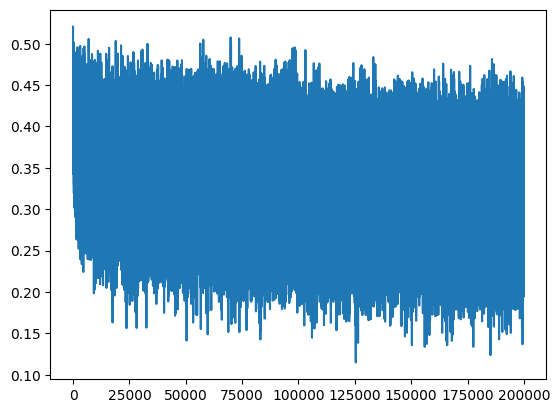

In [18]:
plt.plot(lossi)

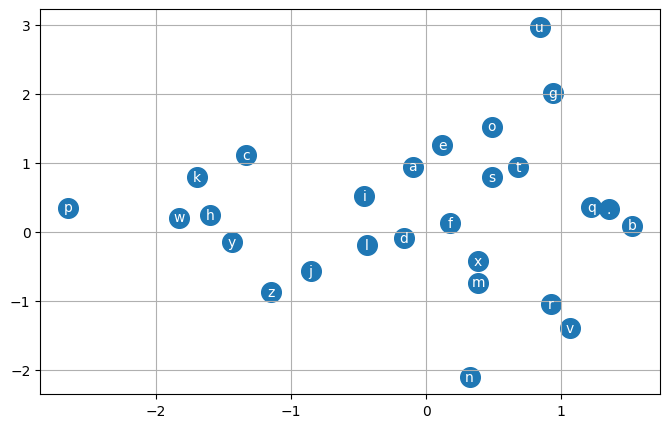

In [19]:
plt.figure(figsize=(8,5)) # visualizing for 2 dimensional embeddings
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [39]:
# sampling from the model

g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
  out = []
  context = [0]* block_size
  while True:
    emb = C[torch.tensor([context])] # (1,block_size,d)
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running)/ bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))


carmah.
ambrie.
khi.
mri.
reety.
skanden.
jazonte.
delynn.
jareei.
nellara.
chaiivon.
leggyd.
bron.
catessan.
sulin.
alianni.
wavero.
dearyn.
kai.
eveilsabeed.


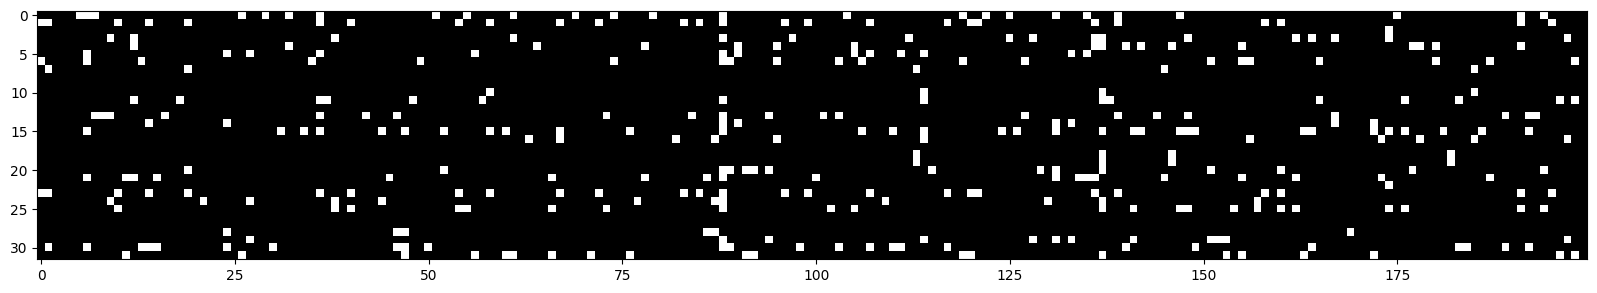

In [17]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# this shows that all white spaces were very very active in a flat tail in all these cases the backward gradient is vanishing and getting destroyed

In [20]:
# PyTorchifying the code and making a deeper network
